In [65]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt 
import pickle 
import matplotlib.lines as mlines
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import ttest_ind,  shapiro, mannwhitneyu, pearsonr
import seaborn as sb
import matplotlib.colors
from tqdm import tqdm 

N_episode = 300
FIGSIZE = (16,9)
colors = ['darkred', 'crimson', 'salmon', 'gold', 'lime', 
          'darkgreen', 'navy', 'royalblue', 'darkviolet', 'magenta'
         ]

LW = 5

In [66]:
def plot_performance(data, X=None, names=None, title="", ylabel="performance", 
                     minimum = -np.inf, maximum=np.inf, log=False, double=False, xlabel="learning episodes"):
    """
    data = [n_param, n_run, episode_length]
    """
    
    if names is None:
        names = [str(j) for j in range(len(data))]
    compute_X = (X is None)
    if len(data)<6:
        ncol = [1,1,2,2,3][len(data)-1] 
    else:
        ncol = len(data)//2
    fig, ax = plt.subplots(figsize=FIGSIZE)
    handles = []
    for i in range(len(data)):
        if (double and i>=len(data)/2):
            linestyle = ":"
            color = colors[i%(len(data)//2)]
        else:
            linestyle = "-"
            color = colors[i%len(colors)]
        
        mean, std = np.mean(data[i], axis=0), np.std(data[i], axis=0)
        mean_p_std = np.minimum(mean+std, maximum)
        mean_m_std = np.maximum(mean-std, minimum)
        
        if compute_X:
            X = [x for x in range(len(mean))]

        for run in range(len(data[i])):
            plt.plot(X, data[i][run], color=color, lw=2, alpha=0.3, linestyle=linestyle)
        plt.plot(X,mean, color = color,lw=LW, linestyle=linestyle)
       # ax.fill_between(X,mean_p_std , mean_m_std, color= color, alpha=0.15)
       # plt.plot(X, mean_p_std, color=color, alpha=0.2)
        #plt.plot(X, mean_m_std, color=color, alpha=0.2)
        handles.append( mlines.Line2D([], [], color = color, linestyle=linestyle, label= names[i]))
    if log:
        plt.yscale("log")
        #if (X[1]-X[0])!=(X[-1]-X[-2]):
        #    plt.xscale("log")
    else:
        if minimum != -np.inf and maximum!=np.inf:
            plt.ylim(minimum,maximum)
        elif minimum != -np.inf:
            plt.ylim(minimum)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(handles=handles, numpoints = 2,ncol=1,bbox_to_anchor=(1.01, 1.))
    plt.show()

In [67]:
def truncate(f, n):
    '''Truncates/pads a float f to n decimal places without rounding'''
    s = '{}'.format(f)
    if 'e' in s or 'E' in s:
        return '{0:.{1}f}'.format(f, n)
    i, p, d = s.partition('.')
    return '.'.join([i, (d+'0'*n)[:n]])

def compute_test(data, coef=1, N=5):
    pairs = []
    for i in range(N-1):
        for j in range(i+1,N):
            pairs.append((i,j))
    res = [[] for _ in range(N)]
    cells = [[ '' for _ in range(N-1)] for _ in range(N-1)]
    for (param1,param2) in pairs:
        data1 = np.array(data[param1])
        data2 = np.array(data[param2])
        stat, p_t = ttest_ind(data1,data2)
        p_t = p_t*coef
        d = truncate( np.mean(data1)-np.mean(data2), 2)
        if d=='0.00' or d=='-0.00':
            d = truncate( np.mean(data1)-np.mean(data2), 3)
            if d=='0.000' or d=='-0.000':
                d = truncate( np.mean(data1)-np.mean(data2), 4)
        if p_t < 0.001:
            res.append((param1, param2, '***'))
            cells[param1][N-1-param2] = d+'\n***'
        elif p_t < 0.01:
            res.append((param1, param2, '**'))
            cells[param1][N-1-param2] = d+'\n**'
        elif p_t < 0.05:
            res.append((param1, param2, '*'))
            cells[param1][N-1-param2] = d+'\n*'
        else:
            cells[param1][N-1-param2] = "ns"
    return res,cells

def plot_boxplot(data, names, ylabel="performance", ylim=None, title=""):
    N = len(data)
    stat,cells = compute_test(data, 3*N*(N-1)/2, N)
    
    plt.subplots(figsize=(12,10))
    
    bplot = sb.boxplot(data=data)
    for i in range(N):
        bplot.artists[i].set_facecolor(colors[i])
    sb.swarmplot( data=data, color='black', edgecolor='black',size=7)
    
    rows = names[:N-1]
    columns = [names[i] for i in range(N-1,0,-1)]
    cell_text = cells
    cellColours = [['white' if N-1-i>j else 'lightgrey' for j in range(N-1)] for i in range(N-1) ]
    the_table = plt.table(cellText=cell_text,
                          rowLabels=rows,
                          cellColours= cellColours,
                          rowColours=colors[:N-1],
                          colColours=[ colors[i] for i in range(N-1,0,-1)],
                          colLabels=columns,
                          cellLoc = 'center',
                          bbox=(1.13,0.1,0.5,0.9))
    
    plt.xticks(range(N), names)
    if not ylim is None:
        plt.ylim(ylim)
    plt.ylabel(ylabel)
    plt.title(title)

In [4]:
with open('data/controller_72k.pk', 'rb') as f:
    samples = pickle.load(f)
R = samples['rewards']
obs = samples['obs']
controller = samples["controller"]


In [3]:
with open('exp/data/random_minitaur.pk', 'rb') as f:
    (R,I) = pickle.load(f)
R = np.array(R)
I= np.array(I)

In [14]:
count = 0
for i in range(len(I)):
    if I[i] == 399:
        if R[i,0] > 2:
            count += 1
count/len(I)

1.3966441434521132e-05

TypeError: list indices must be integers or slices, not tuple

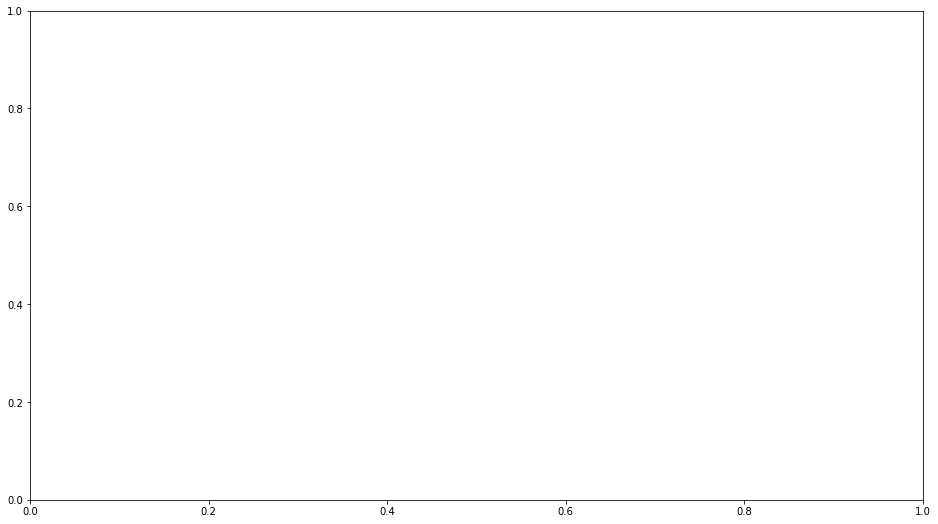

In [5]:
plt.subplots(figsize=(16,9))
plt.hist(R[:,0])
plt.title("Episode length for random episodes")
plt.ylabel('')
plt.xlabel('Number of steps')

In [9]:
good = []
bad = []
count = 0
for i in tqdm(range(len(R))):
    r = R[i]
    pos = obs[i][-1]
    if (r[4] == 0):
        if (pos[28] > 2):  #and (-0.5 < pos[29] < 0.5):
            good.append(i)
        else:
            bad.append(i)

print(len(good), len(bad))

100%|██████████| 72001/72001 [00:00<00:00, 765497.40it/s]

275 11229


In [46]:
with open('good_controllers.pk', 'wb') as f:
    pickle.dump(np.array(controller)[good], f)

In [8]:
count = 0
for i in tqdm(range(len(R))):
    r = R[i]
    pos = obs[i][-1]
    if (r[4] == 0):
        if np.linalg.norm(pos[28:30])>2:
            good.append(i)
        else:
            bad.append(i)

print(len(good), len(bad))

100%|██████████| 72001/72001 [00:00<00:00, 460517.59it/s]

1270 21738


100%|██████████| 72001/72001 [00:00<00:00, 571307.11it/s]


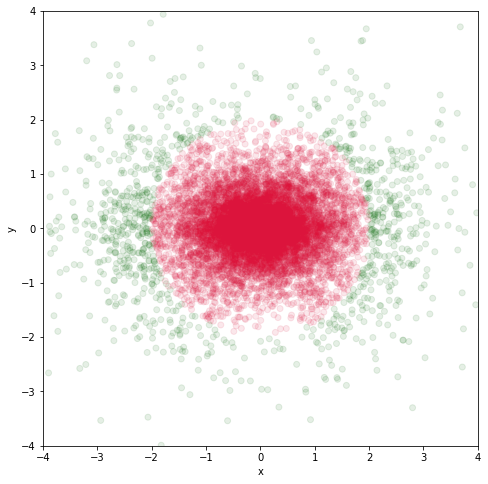

In [6]:
Pos, color = [], []
for i in tqdm(range(len(R))):
    if R[i][-1] == 0:
        pos = obs[i][-1]
        Pos.append(pos)
        if np.linalg.norm(pos[28:30])>2:
            color.append('darkgreen')
        else:
            color.append('crimson')
            
Pos = np.array(Pos)
plt.subplots(figsize=(8,8))
plt.scatter(Pos[:, 28], Pos[:, 29], color=color, alpha=0.1)
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.gca().set_aspect('equal', adjustable='box')
plt.ylabel("y")
plt.xlabel("x");

In [37]:
import numpy as np
from sklearn.decomposition import PCA

X = np.array(controller)[good]
pca = PCA(n_components=16)
y = pca.fit_transform(X)  

print(pca.explained_variance_ratio_)  
print(np.cumsum(pca.explained_variance_ratio_))
#print(pca.singular_values_)
print(pca.components_ )

[0.12116933 0.11247034 0.10903612 0.09651346 0.09266729 0.08387343
 0.06821179 0.06611485 0.03709516 0.03547318 0.03314542 0.03096637
 0.03039198 0.02885988 0.02770752 0.02630386]
[0.12116933 0.23363967 0.34267579 0.43918926 0.53185655 0.61572998
 0.68394177 0.75005662 0.78715178 0.82262496 0.85577038 0.88673675
 0.91712873 0.94598862 0.97369614 1.        ]
[[ 6.76990702e-03 -4.39725378e-03  1.90504824e-02 -1.17584691e-02
  -2.41633139e-03  2.39099452e-02  7.96013324e-04 -3.86573855e-02
  -7.84650389e-02  6.22690360e-01 -7.07985527e-02 -1.55296461e-01
   5.13023115e-01 -5.27694418e-01  1.39014303e-01  1.15553163e-01]
 [ 1.63104335e-02  2.31955969e-02  3.79742182e-02  1.10461870e-02
   2.65958638e-02  5.57428223e-02  1.66707697e-02  4.38803173e-02
  -6.26698760e-01  8.09853610e-02  4.78424118e-01 -2.13091057e-03
  -1.13563848e-01  6.60746201e-02  4.78223064e-01 -3.42709545e-01]
 [ 3.69258048e-02 -4.83807918e-02  3.28785688e-02  7.87376734e-03
  -1.17021996e-02 -1.08295118e-02 -3.3968363

In [25]:
y_all = pca.transform(np.array(controller)[good+bad])
print(pca.explained_variance_ratio_)  

[0.12116933 0.11247034 0.10903612 0.09651346 0.09266729 0.08387343
 0.06821179 0.06611485 0.03709516 0.03547318 0.03314542 0.03096637
 0.03039198 0.02885988 0.02770752 0.02630386]


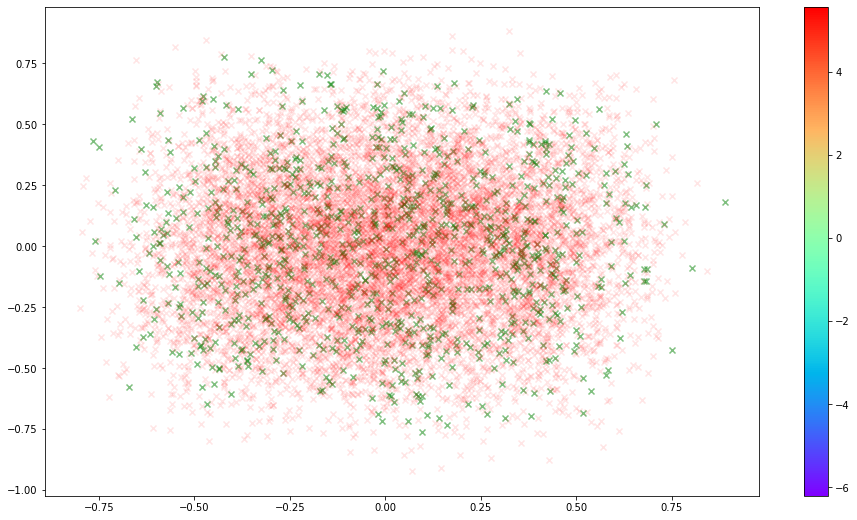

In [28]:
ind = len(good)
y = y_all
i, j = 0, 1
fig, ax = plt.subplots(figsize=FIGSIZE)
cmap = plt.cm.rainbow
norm = matplotlib.colors.Normalize(vmin=min(Pos[good+bad, 28]), vmax=max(Pos[good+bad, 28]))
color=cmap(norm(Pos[good+bad, 28]))

plt.scatter(y[:ind,i], y[:ind,j], marker='x',c='g', alpha=0.5)
plt.scatter(y[ind:,i], y[ind:,j], marker='x',c='r', alpha=0.1)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # only needed for matplotlib < 3.1
fig.colorbar(sm);

/home/timothee/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/home/timothee/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':


NameError: name 'cmap' is not defined

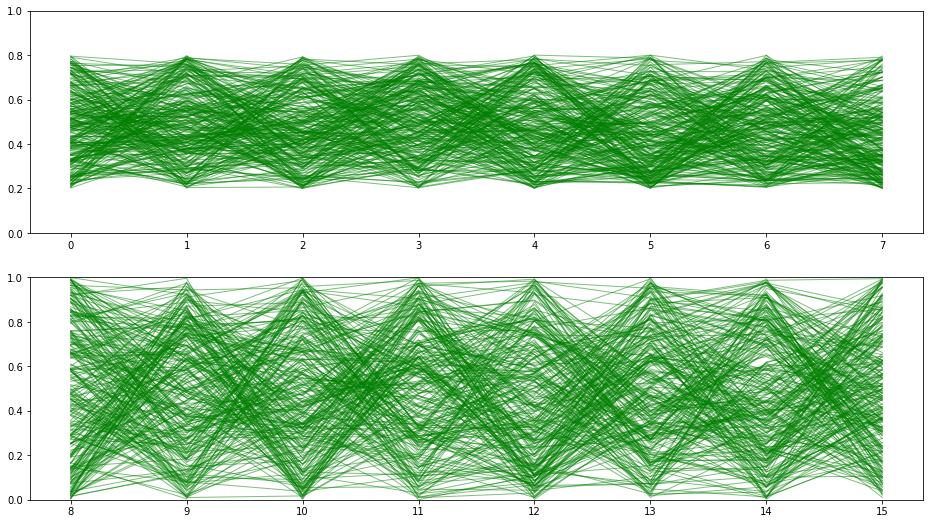

In [11]:
fig, ax = plt.subplots(2,figsize=FIGSIZE)
All = 0
for j in good:
    sols = controller[j]
    color, alpha, lw = 'g' if j in good else 'r', 0.5 if j in good else 0.1, 1
    plt.subplot(211)
    plt.ylim((0,1))
    plt.plot(sols[:8], alpha=alpha, lw=lw, color=color)
    plt.subplot(212)
    plt.ylim((0,1))
    plt.plot(sols[8:], alpha=alpha, lw=lw, color=color)
plt.xticks(range(8),[str(i) for i in range(8, 16)]);
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # only needed for matplotlib < 3.1
fig.colorbar(sm);

  0%|          | 0/11504 [00:00<?, ?it/s]/home/timothee/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/home/timothee/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':
100%|██████████| 11504/11504 [02:49<00:00, 67.76it/s]


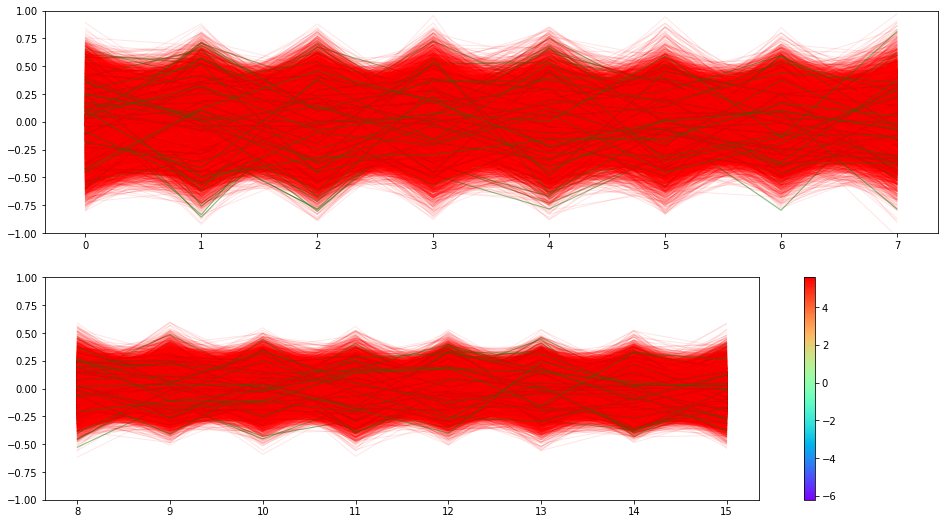

In [33]:
fig, ax = plt.subplots(2,figsize=FIGSIZE)
All = 0
for j in tqdm(range(len(y_all))):
    sols = y_all[j]
    color, alpha, lw = 'g' if j in good else 'r', 0.5 if j in good else 0.1, 1
    plt.subplot(211)
    plt.ylim((-1,1))
    plt.plot(sols[:8], alpha=alpha, lw=lw, color=color)
    plt.subplot(212)
    plt.ylim((-1,1))
    plt.plot(sols[8:], alpha=alpha, lw=lw, color=color)
plt.xticks(range(8),[str(i) for i in range(8, 16)]);
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # only needed for matplotlib < 3.1
fig.colorbar(sm);

In [16]:
path = "exp/log/Saved/DC/"
file = "/logs.mat"

test = "fast_adaptation_embedding/env/data/ant.pk"
import pickle 
import numpy as np
import matplotlib.pyplot as plt 
with open(test, 'rb') as f:
    data = np.array(pickle.load(f))

In [23]:
points = np.array(data[:,0])

In [28]:
X, Y = [], []
for (x,y) in points:
    X.append(x)
    Y.append(y)

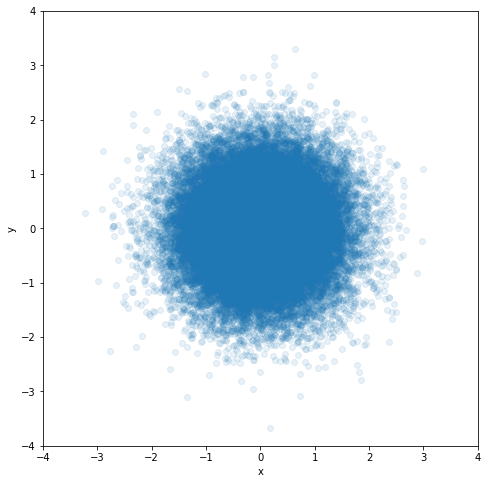

In [35]:
plt.subplots(figsize=(8,8))
plt.scatter(X, Y, alpha=0.1)
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.gca().set_aspect('equal', adjustable='box')
plt.ylabel("y")
plt.xlabel("x");

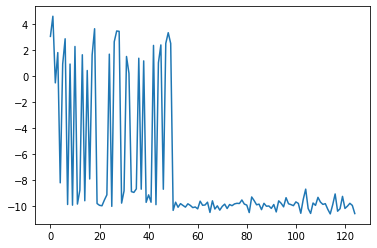

In [54]:
plt.plot(data['reward_sum'][0])

In [25]:
import math
def controller2(params, t):
    steer = params[0]  # Move in different directions
    step_size = params[1]  # Walk with different step_size forward or backward
    leg_extension = params[2]  # Walk on different terrain
    leg_extension_offset = params[3]

    # Robot specific parameters
    back_swing_limit = 0.1
    front_swing_limit = 0.3
    extension_limit = 0.5
    speed = 2

    A = np.clip(step_size + steer, -1, 1)
    B = np.clip(step_size - steer, -1, 1)
    extension = extension_limit * (leg_extension + 1)
    max_extension = np.clip(extension + extension_limit * leg_extension_offset, 0, extension)
    min_extension = np.clip(-extension + extension_limit * leg_extension_offset, -extension, 0)

    # We want legs to move sinusoidally, smoothly
    fl = math.sin(t * speed * 2 * np.pi) * (front_swing_limit * A)
    fr = math.sin(t * speed * 2 * np.pi) * (front_swing_limit * B)

    br = np.sin(t * speed * 2 * np.pi + np.pi) * (back_swing_limit * B)
    bl = np.sin(t * speed * 2 * np.pi + np.pi) * (back_swing_limit * A)

    # We can legs to reach extreme extension as quickly as possible: More like a smoothed square wave
    e1 = np.clip(5.0 * np.sin(t * speed * 2 * np.pi + np.pi / 2), min_extension, max_extension)
    e2 = np.clip(5.0 * np.sin(t * speed * 2 * np.pi + np.pi + np.pi / 2), min_extension, max_extension)
    return np.array([fl, bl, fr, br, e1, e2, e1, e2]) * np.pi / 4

In [26]:
a = []
params = [0, 1, 0, 0]
for t in range(50):
    a.append(controller2(params, t/50.))
a = np.array(a)

In [216]:
l1 = 0.1
l2 = 0.2

def polar(motor_angles):
    """
    Args: 
      The eight desired motor angles
      [sequence_length, LF+LB+RF+RB] where LF=LB=RF=RB=(theta1, theta2) 
    Returns:
        r: array of radius for each leg [sequence_length, 4] 
        theta: array of polar angle [sequence_length, 4] 
        (legs order [LF, LB, RF, RB])
    """
    R = []
    Theta = []
    for i in range(4):
        o1, o2 = motor_angles[:, 2*i], motor_angles[:, 2*i+1]
        beta = (o1+o2)/2
        r = np.sqrt(l2**2-(l1*np.sin(beta))**2)-l1*np.cos(beta)
        R.append(r)
        Theta.append(np.pi+(o1-o2)/2)
    return R, Theta

def cartesian(r, theta):
    """
    Args: 
        r: array of radius for each leg [sequence_length, 4] 
        theta: array of polar angle [sequence_length, 4] 
        (legs order [LF, LB, RF, RB])
    
    Returns:
        (x,y) array of cartesian position of the foot of each legs x=y=[sequence_length, 4]
    """
    return (r*np.cos(theta), r*np.sin(theta))

def ConvertFromLegModel(actions):
    """Convert the actions that use leg model to the real motor actions.

    Args:
      actions: [sequence_length, swing+extention] where swing, extention = [LF, LB, RF, RB]
    Returns:
      The eight desired motor angles that can be used in ApplyActions().
      the orientation of theta1 and theta2 are opposite
      [sequence_length, LF+LB+RF+RB] where LF=LB=RF=RB=(theta1, theta2)
    """
    motor_angle = np.copy(actions)
    scale_for_singularity = 1
    offset_for_singularity = 1.5
    half_num_motors = 4
    quater_pi = math.pi / 4
    for i in range(8):
      action_idx = int(i // 2)
      forward_backward_component = (
          -scale_for_singularity * quater_pi *
          (actions[:, action_idx + half_num_motors] + offset_for_singularity))
      extension_component = (-1)**i * quater_pi * actions[:, action_idx]
      if i >= half_num_motors:
        extension_component = -extension_component
      motor_angle[:, i] = (math.pi + forward_backward_component + extension_component)
    return motor_angle

In [225]:
with open('exp/data/foot_pos.pk', 'rb') as f:
    [Obs, a_action, m_action, position] = pickle.load(f)
position = np.array(position)
m_action = np.array(m_action)
a_action = np.array(a_action)

In [231]:
m_actions = ConvertFromLegModel(a_action)
R, Theta = polar(m_actions)
(x,y) = cartesian(R, Theta)

Text(0.5, 0, 'x')

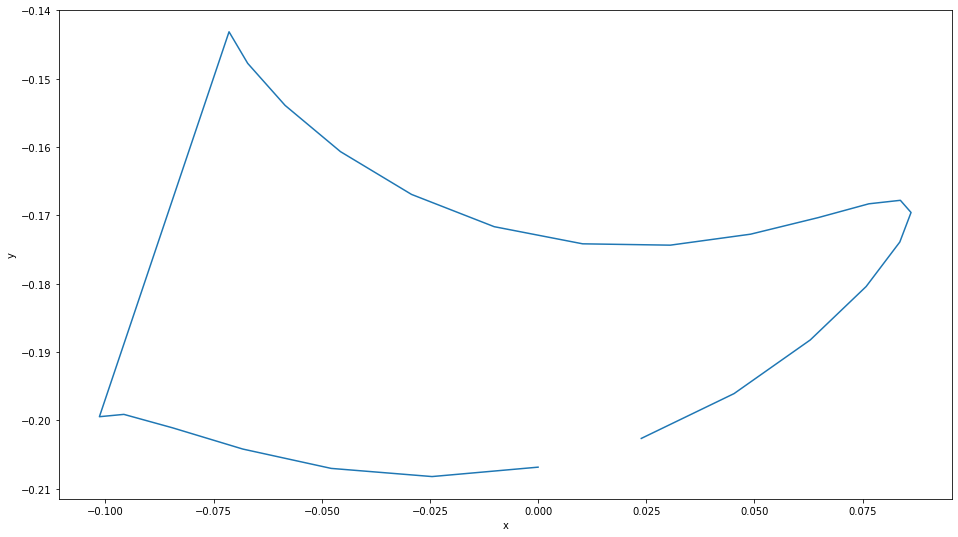

In [264]:
i = 1

plt.subplots(figsize=(16,9))
plt.plot(-y[i,:25],x[i,:25])
plt.ylabel('y')
plt.xlabel('x')

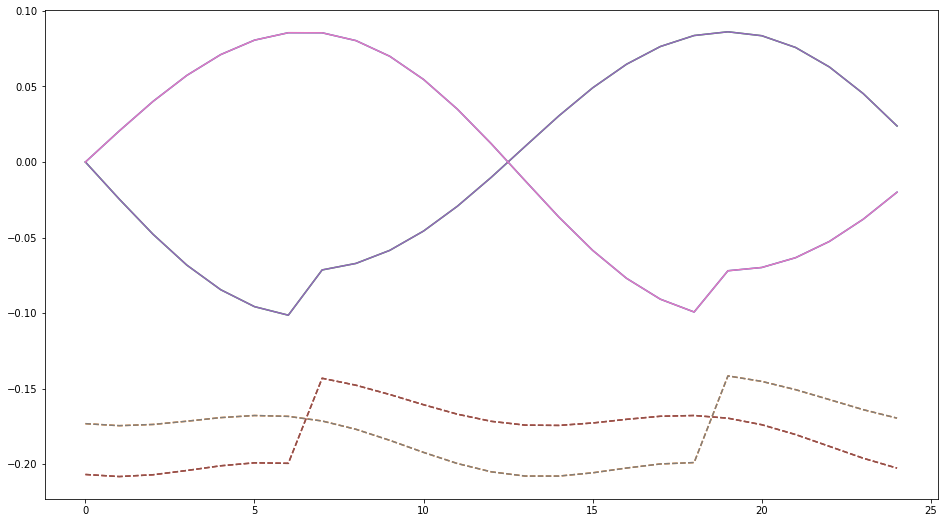

In [274]:

plt.subplots(figsize=(16,9))
for i in range(4):
    plt.plot((-1)**(i<2)*y[i,:25])
    plt.plot(x[i,:25], ls='--')

In [265]:
-y[0,:25],x[0,:25]

(array([-2.12115048e-17,  2.05478424e-02,  4.01315908e-02,  5.73492960e-02,
         7.11121337e-02,  8.06806522e-02,  8.55922409e-02,  8.55518886e-02,
         8.03696221e-02,  6.99962027e-02,  5.46508694e-02,  3.49764671e-02,
         1.21264968e-02, -1.22923625e-02, -3.64310411e-02, -5.84891423e-02,
        -7.69685625e-02, -9.07948129e-02, -9.92864042e-02, -7.19769420e-02,
        -6.98187393e-02, -6.33348039e-02, -5.25732829e-02, -3.78698324e-02,
        -1.99601787e-02]),
 array([-0.17320508, -0.17453091, -0.17372735, -0.17157041, -0.16919509,
        -0.16780293, -0.1683711 , -0.1714275 , -0.17692484, -0.18422894,
        -0.19223276, -0.1995964 , -0.20507966, -0.20788473, -0.20789706,
        -0.20573377, -0.20258008, -0.19987474, -0.1989485 , -0.14158803,
        -0.14521188, -0.15069071, -0.15728213, -0.16393633, -0.16953937]))

In [266]:
-y[1,:25],x[1,:25]

(array([-2.53308135e-17, -2.45138382e-02, -4.78230919e-02, -6.82535797e-02,
        -8.45139198e-02, -9.57378360e-02, -1.01396322e-01, -7.14340797e-02,
        -6.71195919e-02, -5.84761004e-02, -4.56785387e-02, -2.92527316e-02,
        -1.01499686e-02,  1.02983172e-02,  3.05538407e-02,  4.91126653e-02,
         6.47165205e-02,  7.64547663e-02,  8.37397888e-02,  8.62052774e-02,
         8.36110214e-02,  7.58263039e-02,  6.29163655e-02,  4.52948221e-02,
         2.38568116e-02]),
 array([-0.20684179, -0.20821761, -0.20702341, -0.20419247, -0.20108158,
        -0.19911948, -0.19945979, -0.14313846, -0.14775636, -0.15390821,
        -0.16067286, -0.16693338, -0.17165321, -0.17416204, -0.17435828,
        -0.17275229, -0.1703329 , -0.16830671, -0.16779645, -0.16957702,
        -0.17389763, -0.18041138, -0.18822526, -0.19607868, -0.2026369 ]))

In [259]:
y[2,:25],x[2,:25]

(array([ 2.53308135e-17, -2.45138382e-02, -4.78230919e-02, -6.82535797e-02,
        -8.45139198e-02, -9.57378360e-02, -1.01396322e-01, -7.14340797e-02,
        -6.71195919e-02, -5.84761004e-02, -4.56785387e-02, -2.92527316e-02,
        -1.01499686e-02,  1.02983172e-02,  3.05538407e-02,  4.91126653e-02,
         6.47165205e-02,  7.64547663e-02,  8.37397888e-02,  8.62052774e-02,
         8.36110214e-02,  7.58263039e-02,  6.29163655e-02,  4.52948221e-02,
         2.38568116e-02]),
 array([-0.20684179, -0.20821761, -0.20702341, -0.20419247, -0.20108158,
        -0.19911948, -0.19945979, -0.14313846, -0.14775636, -0.15390821,
        -0.16067286, -0.16693338, -0.17165321, -0.17416204, -0.17435828,
        -0.17275229, -0.1703329 , -0.16830671, -0.16779645, -0.16957702,
        -0.17389763, -0.18041138, -0.18822526, -0.19607868, -0.2026369 ]))

In [260]:
y[3,:25],x[3,:25]

(array([ 2.12115048e-17,  2.05478424e-02,  4.01315908e-02,  5.73492960e-02,
         7.11121337e-02,  8.06806522e-02,  8.55922409e-02,  8.55518886e-02,
         8.03696221e-02,  6.99962027e-02,  5.46508694e-02,  3.49764671e-02,
         1.21264968e-02, -1.22923625e-02, -3.64310411e-02, -5.84891423e-02,
        -7.69685625e-02, -9.07948129e-02, -9.92864042e-02, -7.19769420e-02,
        -6.98187393e-02, -6.33348039e-02, -5.25732829e-02, -3.78698324e-02,
        -1.99601787e-02]),
 array([-0.17320508, -0.17453091, -0.17372735, -0.17157041, -0.16919509,
        -0.16780293, -0.1683711 , -0.1714275 , -0.17692484, -0.18422894,
        -0.19223276, -0.1995964 , -0.20507966, -0.20788473, -0.20789706,
        -0.20573377, -0.20258008, -0.19987474, -0.1989485 , -0.14158803,
        -0.14521188, -0.15069071, -0.15728213, -0.16393633, -0.16953937]))